In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import models,Sequential,layers 
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import os
import cv2


Y_START,Y_END=60,135
IMG_SIZE=(200,66)
BATCH = 64
EPOCH = 30


print("TF version:", tf.__version__)
print("GPUs found:", tf.config.list_physical_devices("GPU"))


### Data preprocessing


In [20]:
def preprocess_image(img_bgr):
    
    h,w = img_bgr.shape[:2]
    # Crop the image to get the road
    cropped = img_bgr[60:136, 0:w]
    
    # Convert BGR to YUV
    yuv = cv2.cvtColor(cropped, cv2.COLOR_BGR2YUV)

    # Gaussian blur
    yuv = cv2.GaussianBlur(yuv, (3, 3), 0)

    # Resize
    resized = cv2.resize(yuv, (200, 66), interpolation=cv2.INTER_AREA)

    # Normalize pixel values to range[0,1]
    processed = resized.astype(np.float32) / 255.0

    return processed

def augment_image(
    image, 
    steering_angle, 
    flip_prob=0.5, 
    brightness_prob=0.5, 
    zoom_prob=0.5, 
    pan_prob=0.5, 
    rotate_prob=0.5,
    max_brightness_delta=0.25,   # ~±25% brightness
    max_zoom=0.2,                # up to 20% zoom-in
    max_translation=0.1,         # up to 10% shift in height/width
    max_rotation=0.05            # ~±5% of 2π (~±9°)
):
    """
    Randomly augments an image and adjusts steering angle accordingly.
    
    Args:
        image: 3D tf.Tensor [H, W, C], dtype uint8 or float32.
        steering_angle: float scalar (Python float or 0-D tf.Tensor).
        *_prob: probability of applying each augmentation (0..1).
        max_*: magnitude controls for each operation.
    Returns:
        aug_image: augmented image, float32 in [0,1], shape [H, W, C]
        aug_angle: adjusted steering angle (flipped if image flipped)
    """
    # Ensure float32 in [0,1]
    img = tf.image.convert_image_dtype(image, dtype=tf.float32)
    angle = tf.cast(steering_angle, tf.float32)

    H = tf.shape(img)[0]
    W = tf.shape(img)[1]
    
 # -------- Flip (horizontal) --------
    # If applied, invert steering angle
    do_flip = tf.less(tf.random.uniform([]), flip_prob)
    img = tf.cond(
        do_flip,
        lambda: tf.image.flip_left_right(img),
        lambda: img
    )
    angle = tf.cond(do_flip, lambda: -angle, lambda: angle)

    # -------- Brightness --------
    def brightness(x):
        return tf.clip_by_value(
            tf.image.random_brightness(x, max_delta=max_brightness_delta),
            0.0, 1.0
        )
    img = tf.cond(tf.less(tf.random.uniform([]), brightness_prob),
                  lambda: brightness(img),
                  lambda: img)

    # -------- Zoom (crop center, then resize back) --------
    # Zoom-in only (keeps size by resizing back); simpler & robust
    def zoom(x):
        zoom_factor = 1.0 - tf.random.uniform([], 0.0, max_zoom)  # e.g., 0.8..1.0
        new_h = tf.cast(tf.round(tf.cast(H, tf.float32) * zoom_factor), tf.int32)
        new_w = tf.cast(tf.round(tf.cast(W, tf.float32) * zoom_factor), tf.int32)
        # center-crop to [new_h, new_w]
        offset_h = (H - new_h) // 2
        offset_w = (W - new_w) // 2
        cropped = tf.image.crop_to_bounding_box(x, offset_h, offset_w, new_h, new_w)
        return tf.image.resize(cropped, (H, W), method="bilinear")
    img = tf.cond(tf.less(tf.random.uniform([]), zoom_prob),
                  lambda: zoom(img),
                  lambda: img)

    # -------- Pan (translation) --------
    # Implemented via pad + random crop to original size
    def panning(x):
        # pad by up to max_translation * size, then crop a different window
        pad_h = tf.cast(tf.round(tf.cast(H, tf.float32) * max_translation), tf.int32)
        pad_w = tf.cast(tf.round(tf.cast(W, tf.float32) * max_translation), tf.int32)
        padded = tf.pad(x, [[pad_h, pad_h], [pad_w, pad_w], [0, 0]], mode="REFLECT")
        # pick a random top-left for crop
        max_off_h = 2 * pad_h
        max_off_w = 2 * pad_w
        off_h = tf.random.uniform([], 0, max_off_h + 1, dtype=tf.int32)
        off_w = tf.random.uniform([], 0, max_off_w + 1, dtype=tf.int32)
        return tf.image.crop_to_bounding_box(padded, off_h, off_w, H, W)
    img = tf.cond(tf.less(tf.random.uniform([]), pan_prob),
                  lambda: panning(img),
                  lambda: img)

    # -------- Rotation --------
    # Use Keras preprocessing for rotation (works per-sample)
    def rotate(x):
        layer = tf.keras.layers.experimental.preprocessing.RandomRotation(factor=max_rotation)
        # layer expects a batch; set training=True to ensure effect
        x = layer(tf.expand_dims(x, 0), training=True)
        return tf.squeeze(x, 0)
    img = tf.cond(tf.less(tf.random.uniform([]), rotate_prob),
                  lambda: rotate(img),
                  lambda: img)

    return img, angle

def build_samples(df, data_root="data"):
    paths = (
        df["center"]
        .astype(str)
        .str.replace("\\", "/", regex=False)
        .str.replace(r"^.*?(IMG/.*)$", r"\1", regex=True)
        .map(lambda p: os.path.join(data_root, p))
    ).to_numpy()
    angles = df["steering"].astype(np.float32).to_numpy()
    return paths, angles

def batch_generator(paths, angles, batch_size=64, is_training=True, shuffle=True):
    num_samples = len(paths)
    assert num_samples == len(angles)
    indices = np.arange(num_samples)
    while True:
        if shuffle:
            np.random.shuffle(indices)
        for start in range(0, num_samples, batch_size):
            batch_idx = indices[start:start + batch_size]
            X_batch = []
            y_batch = []
            for i in batch_idx:
                path = paths[i]
                angle = angles[i]
                img_bgr = cv2.imread(path)
                if img_bgr is None:
                    continue
                img_proc = preprocess_image(img_bgr)
                if is_training:
                    img_tf = tf.convert_to_tensor(img_proc, dtype=tf.float32)
                    angle_tf = tf.convert_to_tensor(angle, dtype=tf.float32)
                    img_tf, angle_tf = augment_image(img_tf, angle_tf,flip_prob=.3,brightness_prob=.3,zoom_prob=.3,pan_prob=.3,rotate_prob=.3)
                    img_proc = img_tf.numpy().astype(np.float32)
                    angle = float(angle_tf.numpy())
                X_batch.append(img_proc)
                y_batch.append(angle)
            if len(X_batch) == 0:
                continue
            X_batch = np.stack(X_batch, axis=0).astype(np.float32)
            y_batch = np.asarray(y_batch, dtype=np.float32)
            yield X_batch, y_batch

df = pd.read_csv('./data/driving_log.csv',header=None , names=["center","left",'right','steering','throttle','brake','speed'])
df = df.drop(["left","right","throttle","brake","speed"],axis=1)

X, y = build_samples(df,data_root="data")

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2,random_state=42,shuffle=True)

train = batch_generator(X_train,y_train,batch_size=BATCH,is_training=True,shuffle=True)
test = batch_generator(X_test,y_test,batch_size=BATCH,is_training=False,shuffle=False)


def steps_per_epoch(n_samples, batch_size):
    return int(np.ceil(n_samples / float(batch_size)))


### Model 

In [ ]:
net = Sequential([
    layers.Lambda(lambda z: z, input_shape=(66, 200, 3)),
    layers.Conv2D(24, (5, 5), strides=(2, 2), padding="valid", activation="elu"),
    layers.Conv2D(36, (5, 5), strides=(2, 2), padding="valid", activation="elu"),
    layers.Conv2D(48, (5, 5), strides=(2, 2), padding="valid", activation="elu"),
    layers.Conv2D(64, (3, 3), strides=(1, 1), padding="valid", activation="elu"),
    layers.Conv2D(64, (1, 1), strides=(1, 1), padding="valid", activation="elu"),
    layers.Flatten(name="flatten"),
    layers.Dense(1164, activation="elu", name="fc1_1164"),
    layers.Dense(100, activation="elu", name="fc2_100"),
    layers.Dense(50, activation="elu", name="fc3_50"),
    layers.Dense(10, activation="elu", name="fc4_10"),
    layers.Dense(1, name="steering")
    ])
net.compile(optimizer=Adam(learning_rate=3e-4),loss='mse',metrics=['mae'])
H=net.fit(
    train,
    steps_per_epoch=steps_per_epoch(len(y_train), BATCH),
    validation_data=test,
    validation_steps=steps_per_epoch(len(y_test), BATCH),
    epochs=EPOCH
)

Epoch 1/30
465/465 [==============================] - 390s 839ms/step - loss: 0.1475 - mae: 0.2004 - val_loss: 0.1204 - val_mae: 0.1943
Epoch 2/30
465/465 [==============================] - 149s 321ms/step - loss: 0.1139 - mae: 0.1870 - val_loss: 0.1168 - val_mae: 0.1944
Epoch 3/30
465/465 [==============================] - 139s 298ms/step - loss: 0.1123 - mae: 0.1878 - val_loss: 0.1084 - val_mae: 0.1840
Epoch 4/30
465/465 [==============================] - 139s 299ms/step - loss: 0.1108 - mae: 0.1870 - val_loss: 0.1137 - val_mae: 0.1838
Epoch 5/30
465/465 [==============================] - 149s 320ms/step - loss: 0.1091 - mae: 0.1875 - val_loss: 0.1094 - val_mae: 0.1784
Epoch 6/30
465/465 [==============================] - 164s 352ms/step - loss: 0.1067 - mae: 0.1855 - val_loss: 0.1039 - val_mae: 0.1752
Epoch 7/30
465/465 [==============================] - 159s 341ms/step - loss: 0.1062 - mae: 0.1856 - val_loss: 0.1028 - val_mae: 0.1917
Epoch 8/30
465/465 [============================

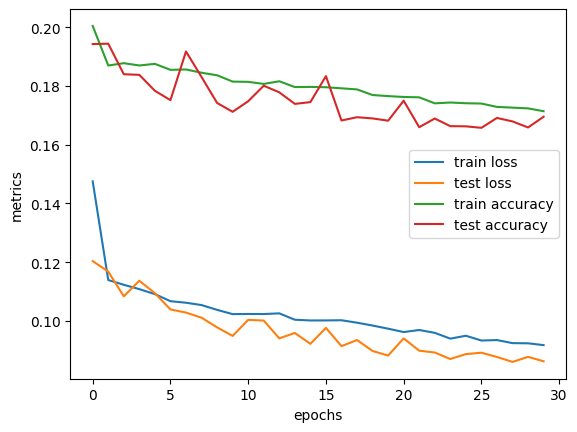

In [22]:
plt.plot(H.history['loss'], label='train loss')
plt.plot(H.history['val_loss'], label='test loss')
plt.plot(H.history['mae'], label='train accuracy')
plt.plot(H.history['val_mae'], label='test accuracy')

plt.legend()
plt.xlabel('epochs')
plt.ylabel('metrics')
plt.show()

In [23]:
net.save("models/model.h5")

In [21]:
testImage = cv2.imread(X[1654])
testImage = preprocess_image(testImage)
cv2.imshow('test',testImage)
cv2.waitKey(0)
cv2.destroyAllWindows()